## SET-UP

In [ ]:
!pip install pymoo > /dev/null 2>&1
!pip install plotly > /dev/null 2>&1
!pip install ipyvolume > /dev/null 2>&1
!pip install altair > /dev/null 2>&1

In [ ]:
%load_ext autoreload
%autoreload 2


import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random
#import AI4NP_detector_opt.sol2.detector2 as detector2
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.util.display.column import Column
from pymoo.util.display.output import Output

from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting


ModuleNotFoundError: No module named 'pymoo'

## Build Classes

In [ ]:
!pip install kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 3.0 MB/s eta 0:00:00


In [ ]:
for tower in region.towers:
  print(f'Generation {tower.generation} : radius {tower.r}')

Generation 1 : radius 5.213714442179438
Generation 3 : radius 52.13714442179438
Generation 2 : radius 16.48721270700128
Generation 3 : radius 52.13714442179438
Generation 1 : radius 5.213714442179438
Generation 1 : radius 5.213714442179438
Generation 1 : radius 5.213714442179438
Generation 1 : radius 5.213714442179438
Generation 0 : radius 1.6487212707001282
Generation 1 : radius 5.213714442179438


In [ ]:
def is_valid_point(new_point, towers, min_distance):
    for tower in towers:
        if math.sqrt((new_point[0] - tower.x) ** 2 + (new_point[1] - tower.y) ** 2) < min_distance:
            return False
    return True

def calculate_radius(generation):
        radius = math.sqrt(((1*10**generation)*math.e))
        return radius

def generate_non_overlapping_towers(num_towers, xl, xh, yl, yh):
    towers = []
    attempts = 0
    max_attempts = num_towers * 100  # Avoid infinite loop

    while len(towers) < num_towers and attempts < max_attempts:
        new_point = (np.random.uniform(xl, xh), np.random.uniform(yl, yh))
        generation = (np.random.randint(0,4))
        radius = calculate_radius(generation)
        if is_valid_point(new_point, towers, 2 * 10 * (1 + generation * 0.2)):
            towers.append(Tower(new_point[0], new_point[1], generation,radius))
        attempts += 1

    if attempts == max_attempts:
        print(f"Warning: Max attempts reached. Generated {len(towers)} towers out of {num_towers} requested.")

    return towers

def closest_point(x, y, points):
  """
  Finds the closest point in a list to a given (x, y) coordinate.

  Args:
    x: The x-coordinate of the reference point.
    y: The y-coordinate of the reference point.
    points: A list of tuples representing (x, y) coordinates.

  Returns:
    The closest point in the list as a tuple (x, y).
  """
  min_distance = float('inf')
  closest = None
  for point in points:
    distance = math.sqrt((x - point.x) ** 2 + (y - point.y) ** 2)
    if distance < min_distance:
      min_distance = distance
      closest = point
  return closest


In [ ]:
# Create a region
region = Region(0, 100, 0, 100,(1,1))
num_towers = 10

# Generate non-overlapping towers
towers = generate_non_overlapping_towers(num_towers, 0, 100, 0, 100)
for tower in towers:
    region.add_tower(tower)

# Draw the region with towers
region.draw()

#Calculate the closest tower to any given x,y coordinate
closest = closest_point(50, 50, towers)
print(f"Closest point: ({closest.x}, {closest.y})")


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('O') to dtype('float32') with casting rule 'same_kind'

In [ ]:
def calculate_total_intensity(x, y, towers,sigma,epsilon=1e-4):
  total_intensity = 0
  for tower in towers:
    distance = math.sqrt((x - tower.x) ** 2 + (y - tower.y) ** 2)
    if distance > 0:  # Avoid division by zero
      intensity = np.exp(-1*((distance/((10**tower.generation)*sigma)**2)))
      total_intensity += intensity
  if total_intensity < (1/math.e):
    print("No signal detected")
    return 0
  else:
    return total_intensity

# Example
x = 51.03
y = 50.70
intensity = calculate_total_intensity(x, y, 50, region.towers)
print(f"Signal intensity at ({x}, {y}): {intensity}")

TypeError: 'int' object is not iterable

In [ ]:
def calculate_single_intensity(x, y, tower, epislon = 1e-4):
  distance = math.sqrt((x - tower.x) ** 2 + (y - tower.y) ** 2)
  if distance > 0:  # Avoid division by zero
    intensity = (1*10^int(tower.r))/(int(distance+epislon)^2)
    return intensity
  else:
    return 0

# UPDATED CLASSES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
class Region():
    def __init__(self, xl: float, xh: float,
                 yl: float, yh: float,
                 spacing:Tuple[float, float],
                 **kwargs
                 ):
        self.xl = xl
        self.xh = xh
        self.yl = yl
        self.yh = yh
        self.grid_spacing = spacing
        self.grid_size = (int((xh - xl) / self.grid_spacing[0]),
                              int((yh - yl) / self.grid_spacing[1])
                          )
        self.towers = []
        self.kwargs = kwargs
        self.XYGrid = np.zeros((self.grid_size[0], self.grid_size[1]), dtype = self.kwargs.get('dtype', np.float32))

    def XYtoIJ(self, x, y) -> Tuple[int, int]:
        i = int((x - self.xl) / self.grid_spacing[0])
        j = int((y - self.yl) / self.grid_spacing[1])
        return (i, j)
    def IJtoXY(self, i, j) -> Tuple[float, float]:
        x = self.xl + i * self.grid_spacing[0]
        y = self.yl + j * self.grid_spacing[1]
        return (x, y)

    def getTowers(self) -> List[Tower]:
        return self.towers

    def update_signal_intensity(self, tower, AddOrRemove = "+"):
    # Create a meshgrid for the x and y coordinates
        if (AddOrRemove == "+"):
          self.XYGrid += tower.intensity
        else:
          self.XYGrid -= tower.intensity

    def remove_tower(self, tower):
        self.towers.remove(tower)
        self.update_signal_intensity(tower, "-")

    def add_tower(self, tower):
        self.towers.append(tower)
        #update XYGrid
        self.update_signal_intensity(tower, "+")

    def draw(self):
        #self.figure.clear()
        plt.xlim(self.xl, self.xh)
        plt.ylim(self.yl, self.yh)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Cell Tower Placement')

        for tower in self.towers:
            tower.draw_tower()

        plt.grid(True, which='both', linestyle='--')

        plt.show()
    def show_intensity(self):
      plt.imshow(self.XYGrid.T, origin='lower', cmap='viridis', vmin = 0.)
      plt.colorbar(label='Signal Intensity')
      plt.xlabel('X')
      plt.ylabel('Y')
      plt.title('Signal Intensity Map')
      plt.show()

    def show_intensity3D(self):
      xx = np.arange(self.xl, self.xh, self.grid_spacing[0])
      yy = np.arange(self.yl, self.yh, self.grid_spacing[1])
      X, Y = np.meshgrid(xx, yy)
      fig = plt.figure()
      ax = fig.add_subplot(111, projection='3d')
      ax.plot_surface(X, Y, self.XYGrid, cmap='viridis')
      ax.set_xlim(self.xl, self.xh)
      ax.set_ylim(self.yl, self.yh)
      ax.set_xlabel('X')
      ax.set_ylabel('Y')
      ax.set_zlabel('Signal Intensity')
      plt.show()


    def calculate_deadzone(self):
      area_region = self.XYGrid.size #((self.xh - self.xl)/self.grid_size[0]) * (self.yh - self.yl / self.grid_size[1])
      area_deadzone = (np.count_nonzero(self.XYGrid < 1/math.e))/area_region
      return area_deadzone*100.0

    def compute_cost(self):
      return sum([tower.cost for tower in self.towers])


In [ ]:
import matplotlib.pyplot as plt
import math
class Tower():
    """_summary_ : The class tower defines the location of the tower and the radius of the tower.
       _author_  : Patton Nelson & Karthik Suresh
    """
    def __init__(self, x, y, generation,r=-1.0,region=None,sigma = None):
        self.x = x # ith position in a grid
        self.y = y # jth position in a grid
        self.generation = generation # the generation of the tower
        self.r_threshold = r
        self.region = region
        self.intensity = None
        self.sigma = sigma
        self.cost = max(100_000*(generation+1), 100_000*10**(generation-1)) if self.generation > 0 else 0.
        #self.cost = 100_000**(generation+1)

    def calculate_radius(self,generation):
        radius = math.sqrt(self.sigma(np.log(10**self.generation)+1))
        return radius
    def calculate_signal_intensity(self, region):
    # Create a meshgrid for the x and y coordinates
        if self.intensity is None:
            self.region = region
        x, y = np.meshgrid(np.arange(region.xl, region.xh, region.grid_spacing[0]),
                        np.arange(region.yl, region.yh, region.grid_spacing[1]))
        if self.sigma is None:
          self.sigma = min(0.01*(region.xh-region.xl), 0.01*(region.yh-region.yl))
        # Calculate the distance from the tower to each cell in the grid
        distance = (x - self.x) ** 2 + (y - self.y) ** 2

        # Calculate the signal intensity for each cell
        if (self.generation < 0):
          self.intensity = 0
        else:
          intensity = np.exp(-1 * (distance / (self.sigma*(10*max(self.generation, 10e-6))) ** 2))
          self.intensity = intensity


    def draw_tower(self):
        plt.scatter(self.x, self.y, c='grey')
        coverage = plt.Circle((self.x, self.y), self.r_threshold, color='red', fill=False)
        plt.gca().add_artist(coverage)
    def show_tower_intensity(self):
        plt.imshow(self.intensity.T, origin='lower', cmap='viridis')
        plt.colorbar(label='Signal Intensity')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Signal Intensity Map for Tower {self.generation}')

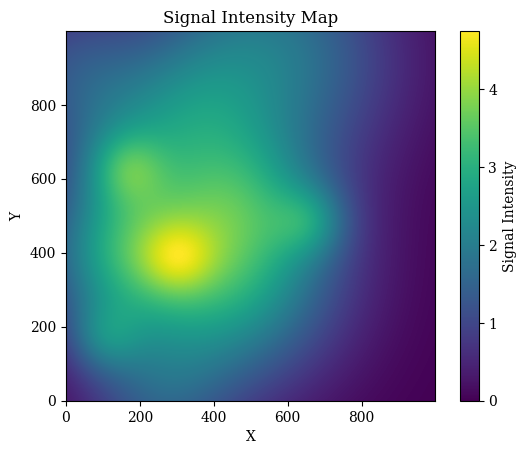

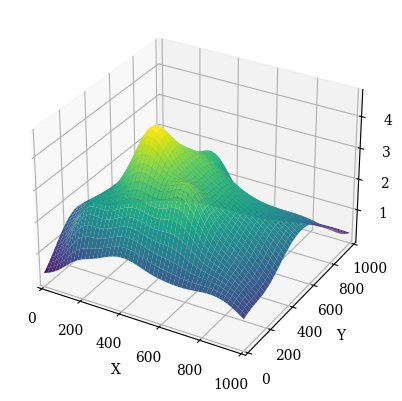

In [ ]:
import matplotlib.pyplot as plt
num_towers = 20
grid = Region(0, 1000, 0, 1000, (1,1), dtype = np.float32)
towers = generate_non_overlapping_towers(num_towers, 0, 1000, 0, 1000)
for tower in towers:
    tower.calculate_signal_intensity(grid)
    grid.add_tower(tower)

# Display the XYGrid
grid.show_intensity()
grid.show_intensity3D()

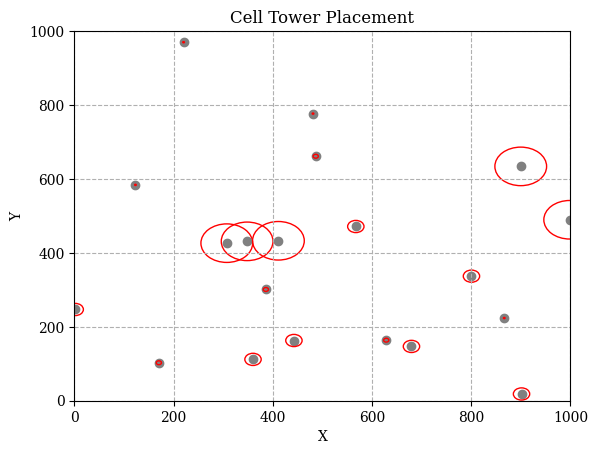

In [ ]:
grid.draw()

In [ ]:
print (grid.calculate_deadzone())
print (grid.compute_cost())

85.47160000000001
34400000.0


In [ ]:
!pip install pymoo

In [ ]:
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
import numpy as np
from pymoo.core.variable import Real, Integer, Choice, Binary

class MyProblem(ElementwiseProblem):
    def __init__(self, regionparams, **kwargs):
        vars = {
            "x0": Real(bounds=(0, 1000)),
            "y0": Real(bounds=(0, 1000)),
            "g0": Integer(bounds=(-1, 3)),
            "x1": Real(bounds=(0, 1000)),
            "y1": Real(bounds=(0, 1000)),
            "g1": Integer(bounds=(-1, 3)),
            "x2": Real(bounds=(0, 1000)),
            "y2": Real(bounds=(0, 1000)),
            "g2": Integer(bounds=(-1, 3)),
            "x3": Real(bounds=(0, 1000)),
            "y3": Real(bounds=(0, 1000)),
            "g3": Integer(bounds=(-1, 3)),
            "x4": Real(bounds=(0, 1000)),
            "y4": Real(bounds=(0, 1000)),
            "g4": Integer(bounds=(-1, 3)),
            "x5": Real(bounds=(0, 1000)),
            "y5": Real(bounds=(0, 1000)),
            "g5": Integer(bounds=(-1, 3)),
            "x6": Real(bounds=(0, 1000)),
            "y6": Real(bounds=(0, 1000)),
            "g6": Integer(bounds=(-1, 3)),
            "x7": Real(bounds=(0, 1000)),
            "y7": Real(bounds=(0, 1000)),
            "g7": Integer(bounds=(-1, 3)),
            "x8": Real(bounds=(0, 1000)),
            "y8": Real(bounds=(0, 1000)),
            "g8": Integer(bounds=(-1, 3)),
            "x9": Real(bounds=(0, 1000)),
            "y9": Real(bounds=(0, 1000)),
            "g9": Integer(bounds=(-1, 3))
        }
        self.regionparams = regionparams
        super().__init__(vars=vars, n_obj=2, n_ieq_constr=0, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        deadzones = []
        costs = []
        grid = Region(**self.regionparams)
        for i in range(10):
            x = X[f'x{i}']
            y = X[f'y{i}']
            generation = X[f'g{i}']
            tower = Tower(x, y, generation)
            tower.calculate_signal_intensity(grid)
            grid.add_tower(tower)

        out["F"] = [grid.calculate_deadzone(), grid.compute_cost()]


<ipython-input-96-035fac4e7cb8>:10: DeprecationWarning: RankAndCrowdingSurvival is deprecated and will be removed in version 0.8.*; use RankAndCrowding operator instead, which supports several and custom crowding diversity metrics.
  algorithm = MixedVariableGA(pop_size=20, survival=RankAndCrowdingSurvival())


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       20 |  4.283306E+01 |  3.046630E+01
     2 |       40 |  3.991867E+01 |  3.046630E+01
     3 |       60 |  3.920400E+01 |  3.046630E+01
     4 |       80 |  3.598912E+01 |  3.046630E+01
     5 |      100 |  3.463175E+01 |  3.046630E+01
     6 |      120 |  3.283823E+01 |  3.046630E+01
     7 |      140 |  3.666695E+01 |  2.6454000000
     8 |      160 |  3.510576E+01 |  2.6454000000
     9 |      180 |  3.385496E+01 |  2.6454000000
    10 |      200 |  3.524821E+01 |  2.6454000000


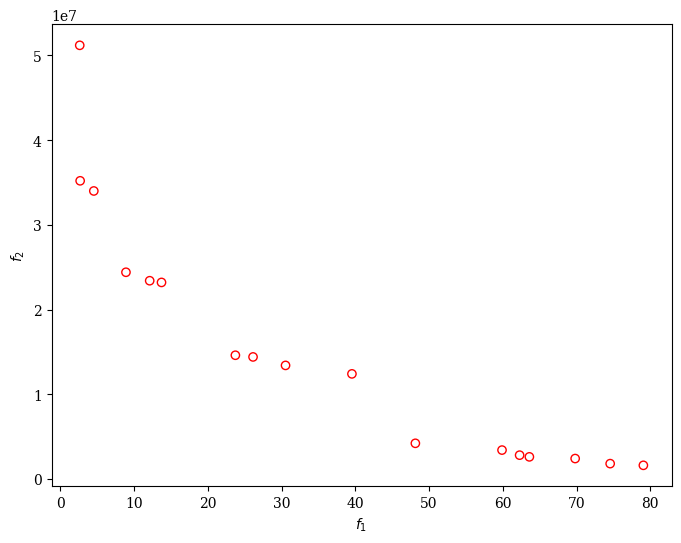

In [ ]:
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga2 import RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableGA
from pymoo.optimize import minimize


regionparams = {"xl": 0., "xh": 1000, "yl": 0. , "yh": 1000., "spacing": (1,1), "kwargs" : {"dtype" : np.float32}}
problem = MyProblem(regionparams=regionparams)

algorithm = MixedVariableGA(pop_size=20, survival=RankAndCrowdingSurvival())

res = minimize(problem,
               algorithm,
               ('n_gen', 10),
               seed=1,
               verbose=True,
               save_history = True)

plot = Scatter()

plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

In [ ]:
a = res.history[0]

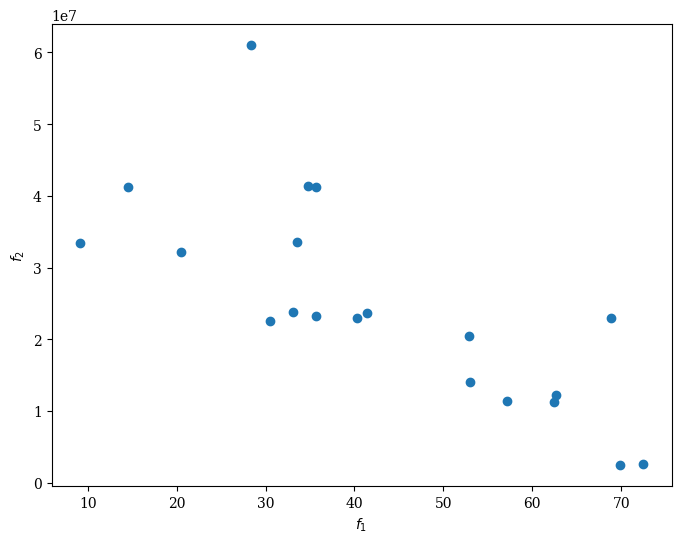

In [ ]:
plot = Scatter()
plot.add(a.pop.get("F"))
plot.show()

In [ ]:
idx = 0
print (a.pop.get("X")[idx])
print (a.pop.get("F")[idx])

{'x0': 417.022004702574, 'y0': 800.7445686755367, 'g0': -1, 'x1': 589.3055369032843, 'y1': 750.8121031361555, 'g1': 0, 'x2': 230.36280837255006, 'y2': 289.7600027395357, 'g2': 2, 'x3': 109.33606758523895, 'y3': 728.0116434027698, 'g3': 3, 'x4': 896.280250540614, 'y4': 15.872980804694237, 'g4': 1, 'x5': 517.5939892992992, 'y5': 660.3318942300559, 'g5': 2, 'x6': 310.32783779771967, 'y6': 778.922243390893, 'g6': 1, 'x7': 297.3313815072722, 'y7': 802.9632373737379, 'g7': 3, 'x8': 187.631672902434, 'y8': 910.7728311738374, 'g8': 1, 'x9': 151.15603934799037, 'y9': 304.210826021154, 'g9': 2}
[5.85433e+01 2.36000e+07]


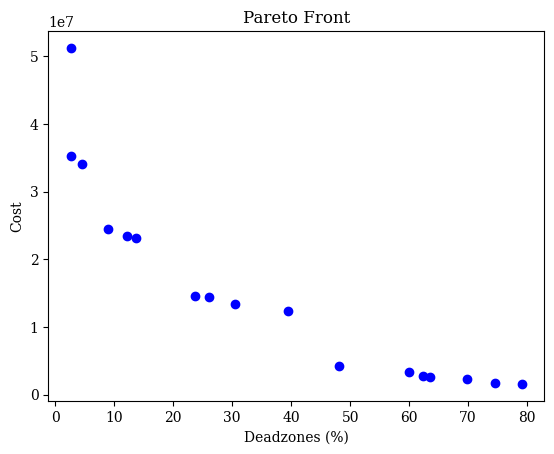

In [ ]:
import matplotlib.pyplot as plt

F = res.F

plt.scatter(F[:, 0], F[:, 1], c="blue")
plt.xlabel("Deadzones (%)")
plt.ylabel("Cost")
plt.title("Pareto Front")
plt.show()


In [ ]:
region = []

for x in res.X:
    rgn = Region(**regionparams)
    for i in range(10):
        xx = x[f'x{i}']
        yy = x[f'y{i}']
        generation = x[f'g{i}']
        tower = Tower(xx, yy, generation)
        tower.calculate_signal_intensity(rgn)
        rgn.add_tower(tower)
    region.append(rgn)
